# Predicting Malicious Cyber Connections
<p style="margin:30px">
    <img style="display:inline; margin-right:50px" width=50% src="https://www.featuretools.com/wp-content/uploads/2017/12/FeatureLabs-Logo-Tangerine-800.png" alt="Featuretools" />
</p>

The general setup for the problem is a common one: we have a single table of log lines recording Internet traffic between various sources. Traffic between a source and destination is labeled as malicious or clean in the dataset, and we'd like to be able to predict ahead of time if a future connection between a source and a destination will be malicious.

We'll demonstrate an end-to-end workflow using this [Cybersecurity Dataset](). This notebook demonstrates a rapid way to predict whether a connection (defined as a source name/destination name pair) is malicious.


## Highlights
* Quickly make end-to-end workflow using log-line cybersecurity data
* Find interesting automatically generated features

Note: this is an extremely imbalanced dataset, and would benefit tremendously from additional positive (malicious) labels

In [1]:
import featuretools as ft
from featuretools.selection import remove_low_information_features
import composeml as cp
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer 
import utils

# Step 1: Understanding the Data
Here we load in the data and do a bit of preprocessing

In [2]:
cyber_df = pd.read_csv("data/CyberFLTenDays.csv")
cyber_df.index.name = "log_id"
cyber_df.reset_index(inplace=True, drop=False)
cyber_df['label'] = cyber_df['label'].map({'N': False, 'A': True}, na_action='ignore')

# Sample down negative examples because very few positives
# Can also do this after the feature engineering step (but doing it here reduces computation time)
cyber_df_pos = cyber_df[cyber_df['label']]
cyber_df_neg = cyber_df[~cyber_df['label']].sample(100000)
cyber_df = pd.concat([cyber_df_pos, cyber_df_neg]).sort_values(['secs'])

In [3]:
cyber_df.head()

,log_id,secs,src_name,dest_name,src_host,dest_host,auth_type,login_type,stage,result,label
0,0,1,C144$@DOM1,SYSTEM@C144,C144,C144,Negotiate,Service,LogOn,Success,False
4,4,4,C1034$@DOM1,SYSTEM@C1034,C1034,C1034,Negotiate,Service,LogOn,Success,False
8,8,18,U119@DOM1,U119@DOM1,C2143,C1790,?,?,TGS,Success,False
9,9,21,C4589$@DOM1,C4589$@DOM1,C4589,C625,?,?,TGS,Success,False
10,10,25,U175@DOM1,U175@DOM1,C1085,C1085,?,?,TGS,Success,False


## Create an EntitySet
To apply Deep Feature Synthesis we need to establish an `EntitySet` structure for our data. Since we're interested in predicting for combinations of "src_name" and "dest_name" (we call this pair a "session"), we need to create a separate normalized entity for "sessions".

In [4]:
es = ft.EntitySet("CyberLL")

# create an index column
cyber_df["name_host_pair"] = cyber_df["src_name"].str.cat(
                                [cyber_df["dest_name"],
                                 cyber_df["src_host"],
                                 cyber_df["dest_host"]],
                                sep=' / ')
cyber_df["session_id"] = cyber_df["src_name"].str.cat(
                                 cyber_df["dest_name"],
                                 sep=' / ')

es.entity_from_dataframe("log",
                         cyber_df,
                         index="log_id",
                         time_index="secs")
es.normalize_entity(base_entity_id="log",
                    new_entity_id="name_host_pairs",
                    index="name_host_pair",
                    additional_variables=["src_name", "dest_name",
                                          "src_host", "dest_host",
                                          #"src_pair",
                                          #"dest_pair",
                                          "session_id",
                                          "label"])
es.normalize_entity(base_entity_id="name_host_pairs",
                    new_entity_id="sessions",
                    index="session_id",
                    additional_variables=["dest_name", "src_name"])

Entityset: CyberLL
  Entities:
    log [Rows: 100329, Columns: 7]
    name_host_pairs [Rows: 62205, Columns: 6]
    sessions [Rows: 19187, Columns: 4]
  Relationships:
    log.name_host_pair -> name_host_pairs.name_host_pair
    name_host_pairs.session_id -> sessions.session_id

In [5]:
cyber_df.head()

,log_id,secs,src_name,dest_name,src_host,dest_host,auth_type,login_type,stage,result,label,name_host_pair,session_id
0,0,1,C144$@DOM1,SYSTEM@C144,C144,C144,Negotiate,Service,LogOn,Success,False,C144$@DOM1 / SYSTEM@C144 / C144 / C144,C144$@DOM1 / SYSTEM@C144
4,4,4,C1034$@DOM1,SYSTEM@C1034,C1034,C1034,Negotiate,Service,LogOn,Success,False,C1034$@DOM1 / SYSTEM@C1034 / C1034 / C1034,C1034$@DOM1 / SYSTEM@C1034
8,8,18,U119@DOM1,U119@DOM1,C2143,C1790,?,?,TGS,Success,False,U119@DOM1 / U119@DOM1 / C2143 / C1790,U119@DOM1 / U119@DOM1
9,9,21,C4589$@DOM1,C4589$@DOM1,C4589,C625,?,?,TGS,Success,False,C4589$@DOM1 / C4589$@DOM1 / C4589 / C625,C4589$@DOM1 / C4589$@DOM1
10,10,25,U175@DOM1,U175@DOM1,C1085,C1085,?,?,TGS,Success,False,U175@DOM1 / U175@DOM1 / C1085 / C1085,U175@DOM1 / U175@DOM1


## Visualize EntitySet

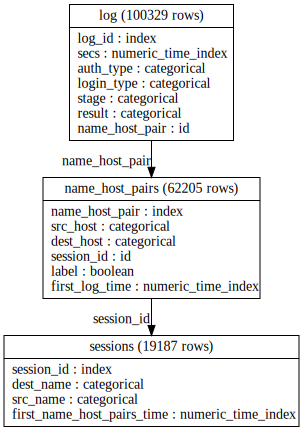

In [6]:
es.plot()

# Generate labels and associated cutoff times

Featuretools can generate features for each session strictly before an associated cutoff time. We will use [Compose](https://compose.featurelabs.com/) to find these cutoff times and generate labels. First, we define our labeling function. 
For a given session:
 * After seeing the same name/host pair N times
 * Predict L observations of this same session in the future
 * Where any connections from this session in a window of size W are malicious.

We will set N = 2 (number of observations to wait for), L = 2 (lead time), and W = 10 (prediction window).

We will incorporate our lead observations into our window for Compose in order to generate the correct cutoffs but ignore it for labeling. 

In [7]:
def malicious_connection(df, lead):
    if len(df.index) > lead + 1: # check to make sure we have enough data
        return df.iloc[lead:]["label"].any() # skip the lead observations when computing labels
        

Next, we create and configure the label maker for our specific prediction problem. We set the `target_entity` to the session ID and the window size to 12 observations (our 10 observation prediction window plus the 2 observation lead time). 

In [8]:
lm = cp.LabelMaker(
    target_entity="session_id",
    time_index="secs",
    labeling_function=malicious_connection,
    window_size=12
)

The label maker will look through each session to label whether or not there was a malicious connection after two observations and a two observation lead. We set the `minimum_data` parameter to 2 to ensure we have two observations before checking for malicious connections. We limit the number of labels we create for a given session using the `num_examples_per_instance` parameter.

In [9]:
label_times = lm.search(
    cyber_df.sort_values('secs'),
    minimum_data=2,
    num_examples_per_instance=1,
    lead=2,
    verbose=True
)

label_times.head()

Elapsed: 00:18 | Remaining: 00:00 | Progress: 100%|██████████████████████████████████████████| session_id: 19187/19187 


,session_id,time,malicious_connection
id,,,
0,ANONYMOUS LOGON@C1065 / ANONYMOUS LOGON@C1065,1970-01-01 00:00:00.000019518,False
1,ANONYMOUS LOGON@C1909 / ANONYMOUS LOGON@C1909,1970-01-01 00:00:00.000199970,False
2,ANONYMOUS LOGON@C2106 / ANONYMOUS LOGON@C2106,1970-01-01 00:00:00.000029819,False
3,ANONYMOUS LOGON@C2606 / ANONYMOUS LOGON@C2606,1970-01-01 00:00:00.000046793,False
4,ANONYMOUS LOGON@C2743 / ANONYMOUS LOGON@C2743,1970-01-01 00:00:00.000066146,False


We can see above the our training examples contain three pieces of information: a session id, the last time we can use data before feature engineering (called the "cutoff time"), and the label to predict. These are called our "label times". Looking at our original dataset, all our times are numeric so we have to change the type of the cutoff_time to match.

We can use describe to print out the distribution with the settings and transforms that were used to make these labels. This is useful as a reference for understanding how the labels were generated from raw data. Also, the label distribution is helpful for determining if we have imbalanced labels.

In [10]:
label_times['time'] = pd.to_numeric(label_times['time'])
label_times.describe()

Label Distribution
------------------
False     4170
True        35
Total:    4205


Settings
--------
gap                                            12
label_type                               discrete
labeling_function            malicious_connection
minimum_data                                    2
num_examples_per_instance                       1
target_entity                          session_id
window_size                                    12


Transforms
----------
No transforms applied



# Compute features using DFS

In [11]:
fm, fl = ft.dfs(entityset=es, target_entity="sessions", cutoff_time=label_times,
                cutoff_time_in_index=True,
                verbose=True, max_depth=3)

Built 111 features
Elapsed: 12:49 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [12]:
fm.head()

,,dest_name,src_name,first_name_host_pairs_time,SUM(name_host_pairs.first_log_time),STD(name_host_pairs.first_log_time),MAX(name_host_pairs.first_log_time),SKEW(name_host_pairs.first_log_time),MIN(name_host_pairs.first_log_time),MEAN(name_host_pairs.first_log_time),COUNT(name_host_pairs),...,MIN(log.name_host_pairs.first_log_time),MEAN(log.name_host_pairs.first_log_time),PERCENT_TRUE(log.name_host_pairs.label),NUM_UNIQUE(log.name_host_pairs.session_id),NUM_UNIQUE(log.name_host_pairs.dest_host),NUM_UNIQUE(log.name_host_pairs.src_host),MODE(log.name_host_pairs.session_id),MODE(log.name_host_pairs.dest_host),MODE(log.name_host_pairs.src_host),malicious_connection
session_id,time,,,,,,,,,,,,,,,,,,,,,
ANONYMOUS LOGON@C1065 / ANONYMOUS LOGON@C1065,19518,ANONYMOUS LOGON@C1065,ANONYMOUS LOGON@C1065,1173,37226,9844.019826,19518,-1.554845,1173,12408.666667,3,...,1173,12408.666667,0.0,1,1,3,ANONYMOUS LOGON@C1065 / ANONYMOUS LOGON@C1065,C1065,C1065,False
ANONYMOUS LOGON@C1909 / ANONYMOUS LOGON@C1909,199970,ANONYMOUS LOGON@C1909,ANONYMOUS LOGON@C1909,74685,74685,NaN,74685,NaN,74685,74685.000000,1,...,74685,74685.000000,0.0,1,1,1,ANONYMOUS LOGON@C1909 / ANONYMOUS LOGON@C1909,C1909,C1909,False
ANONYMOUS LOGON@C2106 / ANONYMOUS LOGON@C2106,29819,ANONYMOUS LOGON@C2106,ANONYMOUS LOGON@C2106,12797,42616,12036.371629,29819,NaN,12797,21308.000000,2,...,12797,18471.000000,0.0,1,1,2,ANONYMOUS LOGON@C2106 / ANONYMOUS LOGON@C2106,C2106,C2106,False
ANONYMOUS LOGON@C2606 / ANONYMOUS LOGON@C2606,46793,ANONYMOUS LOGON@C2606,ANONYMOUS LOGON@C2606,436,436,NaN,436,NaN,436,436.000000,1,...,436,436.000000,0.0,1,1,1,ANONYMOUS LOGON@C2606 / ANONYMOUS LOGON@C2606,C2606,C2606,False
ANONYMOUS LOGON@C2743 / ANONYMOUS LOGON@C2743,66146,ANONYMOUS LOGON@C2743,ANONYMOUS LOGON@C2743,33046,33046,NaN,33046,NaN,33046,33046.000000,1,...,33046,33046.000000,0.0,1,1,1,ANONYMOUS LOGON@C2743 / ANONYMOUS LOGON@C2743,C2743,C2743,False


### One-Hot-Encode categorical features and remove features with low information

In [13]:
fm_encoded, fl_encoded = ft.encode_features(fm, fl)
fm_encoded, fl_encoded = remove_low_information_features(fm_encoded, fl_encoded)

# Machine Learning

Now that we have a feature matrix and associated labels, we can build a standard machine learning pipeline with a RandomForestClassifier

First, split up the data into train and test sets

In [14]:
train, test = train_test_split(fm_encoded, test_size=0.2, shuffle=True)

In [15]:
X_train = train
y_train = X_train.pop('malicious_connection').astype('bool')
X_test = test
y_test = X_test.pop('malicious_connection').astype('bool')

### Construct the model

In [16]:
# imputer = Imputer(missing_values='NaN', strategy="mean", axis=0)
import numpy as np
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
scaler = StandardScaler()
clf = RandomForestClassifier(n_jobs=-1)
model = Pipeline([("imputer", imputer),
                  ("scaler", scaler),
                  ("rf", clf)])

### Fit the model, then score it

In [17]:
model.fit(X_train, y_train)
    
probs = model.predict_proba(X_test)
score = roc_auc_score(y_test, probs[:,1])
print('ROC AUC Score: {:.2f}'.format(score))

ROC AUC Score: 0.59


## View the most important features
according to the Random Forest

In [18]:
high_imp_feats = utils.feature_importances(X_train, clf, feats=10)

1: PERCENT_TRUE(log.name_host_pairs.label) [0.059]
2: PERCENT_TRUE(name_host_pairs.label) [0.051]
3: MIN(log.secs) [0.040]
4: MIN(name_host_pairs.first_log_time) [0.037]
5: MEAN(name_host_pairs.MIN(log.secs)) [0.031]
6: MIN(log.name_host_pairs.first_log_time) [0.029]
7: first_name_host_pairs_time [0.026]
8: MEAN(name_host_pairs.first_log_time) [0.023]
9: STD(log.secs) [0.022]
10: MAX(name_host_pairs.first_log_time) [0.021]
-----



## Save output files

In [19]:
import os

try:
    os.mkdir("output")
except:
    pass

fm_encoded.to_csv('output/feature_matrix.csv')
label_times.to_csv('output/cutoffs.csv')

<p>
    <img src="https://www.featurelabs.com/wp-content/uploads/2017/12/logo.png" alt="Featuretools" />
</p>

Featuretools was created by the developers at [Feature Labs](https://www.featurelabs.com/). If building impactful data science pipelines is important to you or your business, please [get in touch](https://www.featurelabs.com/contact/).